In [1]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image


In [2]:
pfcn_small = np.load('./pfcn_small.npz')

In [3]:
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

In [4]:
train_images[train_images !=0][:10]

array([0.23627451, 0.34803922, 0.64705882, 0.24509804, 0.35686275,
       0.65588235, 0.25490196, 0.36470588, 0.66470588, 0.2372549 ])

In [7]:
print(train_images.dtype)


float64


In [9]:
train_images.shape

(1700, 100, 75, 3)

In [10]:
np.min(train_images), np.max(train_images)

(0.0, 1.0)

In [11]:
from skimage import color

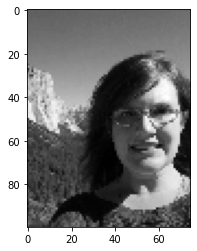

In [13]:
plt.imshow(color.rgb2gray(train_images[0]), cmap = 'gray')
plt.show()

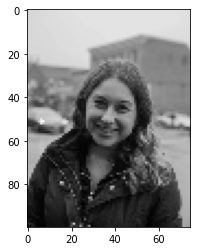

(100, 75)


In [17]:
train_gray_images = color.rgb2gray(train_images)
test_gray_images = color.rgb2gray(test_images)
plt.imshow(train_gray_images[5], cmap = 'gray')
plt.show()

print(train_gray_images[5].shape)

In [18]:
train_gray_images = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in test_images])

print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


In [19]:
#transepose 확인 
#2차원 배열
A = np.arange(6).reshape(2,3)
A

array([[0, 1, 2],
       [3, 4, 5]])

In [21]:
#T를 이용해서 2행 3열을 3행2열로 역으로 바꾸는 메소드
A.T

array([[0, 3],
       [1, 4],
       [2, 5]])

In [22]:
#transpose메소드는 원하는대로 할 수 있음 기본은 역으로. 
A.transpose() 

array([[0, 3],
       [1, 4],
       [2, 5]])

In [23]:
np.transpose(A)

array([[0, 3],
       [1, 4],
       [2, 5]])

In [28]:
#3차원 배열 
A = np.arange(24).reshape(2,3,4)
A

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [32]:
at = A.T
print(at)
print(at.shape)

[[[ 0 12]
  [ 4 16]
  [ 8 20]]

 [[ 1 13]
  [ 5 17]
  [ 9 21]]

 [[ 2 14]
  [ 6 18]
  [10 22]]

 [[ 3 15]
  [ 7 19]
  [11 23]]]
(4, 3, 2)


In [34]:
#괄호안에 입력한 것은 axis번호다. 기존 shape인(2,3,4)는 각각 axis 0, 1, 2에 매칭되어 있다. 
atrans= A.transpose((2,1,0)) #새로 입력한 (2,1,0)은 순서를 아래와 같이 바꾼다는 것을 의미한다.=>(4,3,2)
print(atrans)
print(atrans.shape)

[[[ 0 12]
  [ 4 16]
  [ 8 20]]

 [[ 1 13]
  [ 5 17]
  [ 9 21]]

 [[ 2 14]
  [ 6 18]
  [10 22]]

 [[ 3 15]
  [ 7 19]
  [11 23]]]
(4, 3, 2)


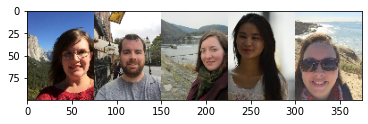

In [35]:
plt.imshow(np.hstack(train_images[:5]))
plt.show()

In [36]:
train_images[:5].shape # 0=5, 1=100, 2=75, 3=3

(5, 100, 75, 3)

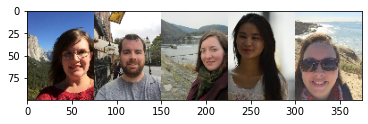

In [39]:
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape((100,-1,3)))
plt.show()

# 칼라 -> 흑백 모델링 

In [43]:
from tensorflow.keras.layers import Conv2D, Dense, Input, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.layers import MaxPool2D, Dropout, BatchNormalization, Activation, concatenate
from tensorflow.keras.models import Model

In [44]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x 

In [45]:
def U_Net():
    inputs = Input((100, 75, 3))
    # 원 논문에선 64 - 128 - 256- 512 - 1024
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding='valid', output_padding=((0,1)))(c5)
    c6 = concatenate([u6, c4])
    c6 = Dropout(0.1)(c6)
    c6 = conv2d_block(c6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=((1,0)))(c6)
    c7 = concatenate([u7, c3])
    c7 = Dropout(0.1)(c7)
    c7 = conv2d_block(c7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=((0,1)))(c7)
    c8 = concatenate([u8, c2])
    c8 = Dropout(0.1)(c8)
    c8 = conv2d_block(c8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=((0,1)))(c8)
    c9 = concatenate([u9, c1])
    c9 = Dropout(0.1)(c9)
    c9 = conv2d_block(c9, 16)

    outputs = Conv2D(1,1, activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model

In [46]:
# unet_black() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = U_Net()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [47]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='mae', optimizer='adam', metrics=['acc'])

In [48]:
# train_images 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(
    train_images,
    train_gray_images,
    validation_data =(test_images, test_gray_images),
    epochs=10,
    verbose = 1
)

Epoch 1/10
54/54 [==============================] - 3s 51ms/step - loss: 0.0711 - acc: 0.0114 - val_loss: 0.2004 - val_acc: 0.0181
Epoch 2/10
54/54 [==============================] - 2s 31ms/step - loss: 0.0374 - acc: 0.0116 - val_loss: 0.1805 - val_acc: 0.0181
Epoch 3/10
54/54 [==============================] - 2s 31ms/step - loss: 0.0312 - acc: 0.0116 - val_loss: 0.1505 - val_acc: 0.0181
Epoch 4/10
54/54 [==============================] - 2s 31ms/step - loss: 0.0302 - acc: 0.0116 - val_loss: 0.1148 - val_acc: 0.0181
Epoch 5/10
54/54 [==============================] - 2s 31ms/step - loss: 0.0287 - acc: 0.0116 - val_loss: 0.0862 - val_acc: 0.0181
Epoch 6/10
54/54 [==============================] - 2s 31ms/step - loss: 0.0257 - acc: 0.0116 - val_loss: 0.0515 - val_acc: 0.0181
Epoch 7/10
54/54 [==============================] - 2s 31ms/step - loss: 0.0275 - acc: 0.0116 - val_loss: 0.0344 - val_acc: 0.0181
Epoch 8/10
54/54 [==============================] - 2s 31ms/step - loss: 0.0250 - a

# Segmentation

In [49]:
# pfcn_small.npz에서 train_images, test_images, train_mattes, test_mattes를 np array로 로드하세요.
pfcn_small = np.load('./pfcn_small.npz')

In [53]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

In [54]:
train_images.shape, train_mattes.shape

((1700, 100, 75, 3), (1700, 100, 75))

In [59]:
from ckimage import color
train_mattes = train_mattes[...,tf.newaxis]
test_mattes = test_mattes[...,tf.newaxis]
print(train_images.shape, train_mattes.shape)
print(test_images.shape, test_mattes.shape)
print(type(test_mattes))

(1700, 100, 75, 3) (1700, 100, 75, 1)
(300, 100, 75, 3) (300, 100, 75, 1)
<class 'numpy.ndarray'>


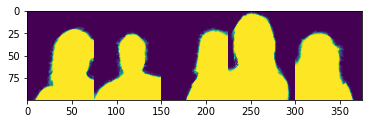

In [61]:
plt.imshow(train_mattes[:5].transpose([1,0,2,3]).reshape((100, -1)))
plt.show()

In [63]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

def ae_like():
    inputs = Input((100,75, 3))
    x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent = Dense(10)(x)

    x = Dense((13 * 10 * 128))(latent)
    x = Reshape((13, 10, 128))(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)

    x = Conv2D(1, (1,1), (1,1), activation='sigmoid')(x)

    model = Model(inputs, x)
    return model

In [64]:
# 만든 모델에 loss는 mse, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='mse', optimizer='adam', metrics=['acc'])

In [65]:
# train_images 학습시키고 25 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs= 25, verbose=1)

Epoch 1/25
54/54 [==============================] - 20s 378ms/step - loss: 0.1636 - acc: 0.7097 - val_loss: 0.1010 - val_acc: 0.8046
Epoch 2/25
54/54 [==============================] - 20s 364ms/step - loss: 0.0699 - acc: 0.8442 - val_loss: 0.0899 - val_acc: 0.8105
Epoch 3/25
54/54 [==============================] - 20s 367ms/step - loss: 0.0533 - acc: 0.8613 - val_loss: 0.0690 - val_acc: 0.8406
Epoch 4/25
54/54 [==============================] - 20s 369ms/step - loss: 0.0453 - acc: 0.8689 - val_loss: 0.0666 - val_acc: 0.8415
Epoch 5/25
54/54 [==============================] - 20s 370ms/step - loss: 0.0388 - acc: 0.8760 - val_loss: 0.0718 - val_acc: 0.8388
Epoch 6/25
54/54 [==============================] - 20s 372ms/step - loss: 0.0356 - acc: 0.8788 - val_loss: 0.0500 - val_acc: 0.8621
Epoch 7/25
54/54 [==============================] - 20s 370ms/step - loss: 0.0316 - acc: 0.8830 - val_loss: 0.0519 - val_acc: 0.8622
Epoch 8/25
54/54 [==============================] - 20s 370ms/step - 

# Segmentation 다른 예제

In [76]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt


cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [70]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [71]:
## segmentation을 위한 annotation이 되어 있는 file의 수 확인
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png']
len(seg_files)

7390

In [75]:
np.array(image_files[0])

array('Abyssinian_1.jpg', dtype='<U16')

In [77]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제, xml도 같이 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  seg_file = os.path.splitext(image_file)[0]+'.png'
  seg_path = os.path.join(seg_dir, seg_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)
    os.remove(seg_path)

Abyssinian_34.jpg P
(202, 250)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_145.jpg P
(188, 216)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_191.jpg P
(214, 300)
staffordshire_bull_terrier_2.jpg L
(282, 500)
staffordshire_bull_terrier_22.jpg L
(500, 364)


In [78]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [79]:
## segmentation을 위한 annotation이 되어 있는 file의 수 확인
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png']
len(seg_files)

7378

In [84]:
#클래스 리스트 만들기
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [81]:
class_list.sort()
class_list[0]

'Abyssinian'

In [85]:
#딕셔너리 생성
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Bengal': 0,
 'Bombay': 1,
 'samoyed': 2,
 'wheaten_terrier': 3,
 'yorkshire_terrier': 4,
 'scottish_terrier': 5,
 'american_pit_bull_terrier': 6,
 'keeshond': 7,
 'leonberger': 8,
 'english_cocker_spaniel': 9,
 'english_setter': 10,
 'pomeranian': 11,
 'german_shorthaired': 12,
 'great_pyrenees': 13,
 'Abyssinian': 14,
 'saint_bernard': 15,
 'Egyptian_Mau': 16,
 'Birman': 17,
 'chihuahua': 18,
 'basset_hound': 19,
 'staffordshire_bull_terrier': 20,
 'beagle': 21,
 'japanese_chin': 22,
 'shiba_inu': 23,
 'Siamese': 24,
 'Persian': 25,
 'Sphynx': 26,
 'British_Shorthair': 27,
 'Ragdoll': 28,
 'boxer': 29,
 'havanese': 30,
 'Russian_Blue': 31,
 'pug': 32,
 'Maine_Coon': 33,
 'american_bulldog': 34,
 'miniature_pinscher': 35,
 'newfoundland': 36}

In [86]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [87]:
image_files.sort()

In [88]:
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']